In [2]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchinfo import summary

In [3]:
# Load and show the dataset from the specified path
file_path = "D:/processed_anomaly_training_loan_data.csv"

# Check if the file exists
if os.path.exists(file_path):
    df = pd.read_csv(file_path, header=0)
    print("Dataset loaded successfully.")
    df.head()  # Show first 5 rows, consider inspecting more if needed
else:
    print(f"File not found at {file_path}")

df.head()

Dataset loaded successfully.


,id,member_id,loan_amnt,int_rate,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag,anomaly_score,anomaly
0,10000001,11983056.0,7550,16.24,28000.0,100.0,96.0,8.40,0.0,17.0,72.0,4000.0,3828.953801,5759.0,99,0.0,0.105777,1
1,10000002,12002921.0,27050,10.99,55000.0,25.0,53.9,22.87,0.0,8.0,61.2,35700.0,34359.940730,114834.0,353,0.0,0.107448,1
2,10000003,11983096.0,12000,10.99,60000.0,0.0,15.9,4.62,1.0,3.0,24.0,18100.0,16416.617760,7137.0,157,0.0,0.117730,1
3,10000004,12003142.0,28000,7.62,325000.0,16.7,67.1,18.55,1.0,3.0,54.6,42200.0,38014.149760,799592.0,365,0.0,-0.006403,-1
4,10000005,11993233.0,12000,13.53,40000.0,33.3,79.6,16.94,0.0,17.0,68.8,7000.0,6471.462236,13605.0,157,0.0,0.135942,1


Minority class ratio: 0.0698
Majority class ratio: 0.9302


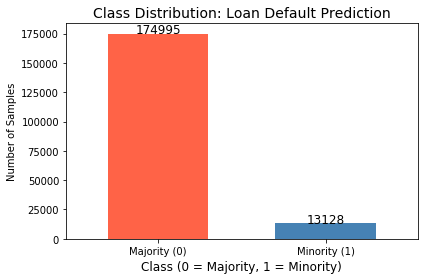

In [4]:
# Calculate the number of samples in each class (minority and majority)
minority_count = df[df['bad_flag'] == 1].shape[0]
majority_count = df[df['bad_flag'] == 0].shape[0]
total_count = len(df)

minority_ratio = minority_count / total_count  # Proportion of the minority class
majority_ratio = majority_count / total_count  # Proportion of the majority class

print(f"Minority class ratio: {minority_ratio:.4f}")
print(f"Majority class ratio: {majority_ratio:.4f}")

# Plot class distribution
class_counts = df['bad_flag'].value_counts()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['#FF6347', '#4682B4'], width=0.6)

plt.title("Class Distribution: Loan Default Prediction", fontsize=14)
plt.xlabel("Class (0 = Majority, 1 = Minority)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Majority (0)', 'Minority (1)'], rotation=0, fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)

# Add class count as labels above the bars
for i, count in enumerate(class_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.tight_layout() 
plt.show()

shape of original training set: (150498,)
shape of SMOTE training set: (215027,)

Class distribution in original training set: {0.0: 140056, 1.0: 10442}
Class distribution in resampled training set: {0.0: 89477, 1.0: 125550}


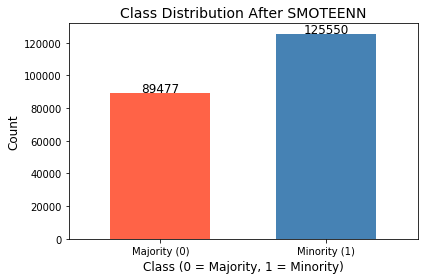

In [5]:
# Splitting data into training and testing sets
X = df.drop(columns=['bad_flag','anomaly_score','anomaly'], axis=1)
y = df['bad_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Handling class imbalance using SMOTEENN (SMOTE + Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=123)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

print(f'shape of original training set: {y_train.shape}')
print(f'shape of SMOTE training set: {y_train_res.shape}')

# Display the class distribution before and after resampling
print(f'\nClass distribution in original training set: {dict(Counter(y_train))}')
print(f'Class distribution in resampled training set: {dict(Counter(y_train_res))}')

# Convert Counter to a pandas Series for easy plotting
resampled_counter = pd.Series(Counter(y_train_res))

# Plot the class distribution after resampling
plt.figure(figsize=(6, 4))
resampled_counter.plot(kind='bar', color=['#FF6347', '#4682B4'], width=0.6)

plt.title("Class Distribution After SMOTEENN", fontsize=14)
plt.xlabel("Class (0 = Majority, 1 = Minority)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Majority (0)', 'Minority (1)'], rotation=0, fontsize=10)

for i, count in enumerate(resampled_counter):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [6]:
# Scale the resampled data
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)  # Don't scale the test data yet

# Convert to PyTorch tensors
X_res_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_res_tensor = torch.tensor(y_train_res.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


# Define the Neural Network model with one hidden layer
hidden_size=64 # Number of neurons in the hidden layer

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size = hidden_size):
        super(SimpleNN, self).__init__()
        # Define the layers
        self.hidden_layer = nn.Linear(input_size, hidden_size)  # Hidden layer
        self.dropout = nn.Dropout(0.3)  # Dropout layer with 30% dropout
        self.output_layer = nn.Linear(hidden_size, 1)  # Output layer (1 neuron for binary classification)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification        
    
    def forward(self, x):
        x = F.relu(self.hidden_layer(x))  # Apply ReLU activation to the hidden layer
        x = self.dropout(x)  # dropout to reduce overfitting
        x = self.output_layer(x)  # Pass through the output layer
        x = self.sigmoid(x)  # Sigmoid activation to output probabilities (0 or 1)
        return x

# Initialize the model
input_size = X_train_res.shape[1]
model = SimpleNN(input_size)

In [7]:
# Function to calculate F1 score by applying a threshold
def calculate_f1_score(pred, y, threshold=0.5):
    pred = (pred >= threshold).astype(float)  # Apply threshold and convert to float (0.0 or 1.0)
    f1 = f1_score(y, pred)  # Calculate F1 score
    return f1

# manual grid search function for hyperparameter tuning using AUC and F1 score evaluation
def grid_search(X_train, y_train, X_val, y_val, hidden_sizes, learning_rates):
    best_auc = 0
    best_f1 = 0
    best_model = None
    best_params = None
    
    for hidden_size in hidden_sizes: # Loop over different hidden layer sizes
        for lr in learning_rates:
            model = SimpleNN(input_size=X_train.shape[1], hidden_size=hidden_size) # Initialize the model
            
            # Define the loss and optimizer
            criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with Sigmoid activation
            optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer
            
            # Train the model
            model.train()
            num_epochs = 50  # Define the number of epochs 
            for epoch in tqdm(range(num_epochs), desc=f"Training {hidden_size}-{lr}"):
                optimizer.zero_grad() # Clear previous gradients
                outputs = model(X_train) # Forward pass through the model
                loss = criterion(outputs, y_train.float().view(-1, 1))  # Compute loss (ensure y_train is float32)
                loss.backward()  # Backpropagation
                optimizer.step() # Update model weights
            
            # Evaluate the model on the validation set
            model.eval()
            with torch.no_grad(): # No need to compute gradients during evaluation
                outputs = model(X_val).squeeze(1)  # Get output and remove the extra dimension
                auc = roc_auc_score(y_val, outputs.numpy())
                f1 = calculate_f1_score(outputs.numpy(), y_val.numpy())  # Convert tensors to numpy for scoring

            print(f"Hidden Size: {hidden_size}, Learning Rate: {lr}, AUC: {auc:.4f}, F1 Score: {f1:.4f}")
            
            # Update the best model
            if auc > best_auc and f1 > best_f1:
                best_auc = auc
                best_f1 = f1
                best_model = model
                best_params = (hidden_size, lr)
                
    # Return the best model and its parameters
    print(f"Best AUC: {best_auc:.4f}, Best F1: {best_f1:.4f} with params: {best_params}")
    return best_model, best_params

In [8]:
# Define the hidden sizes and learning rates to test during grid search
hidden_sizes = [16, 32, 64]  # Number of neurons in the hidden layer
learning_rates = [0.001, 0.002, 0.003]  # Learning rates to test

# Perform grid search to find the best model and parameters based on AUC and F1 score
best_model, best_params = grid_search(X_res_tensor, y_res_tensor, X_test_tensor, y_test_tensor,
                                      hidden_sizes, learning_rates)

# Save the best model as the final model
final_model = best_model  # The model with the best hyperparameters

Training 16-0.001: 100%|███████████████████████| 50/50 [00:04<00:00, 11.87it/s]


Hidden Size: 16, Learning Rate: 0.001, AUC: 0.6505, F1 Score: 0.1861


Training 16-0.002: 100%|███████████████████████| 50/50 [00:04<00:00, 12.50it/s]


Hidden Size: 16, Learning Rate: 0.002, AUC: 0.6884, F1 Score: 0.2129


Training 16-0.003: 100%|███████████████████████| 50/50 [00:04<00:00, 12.05it/s]


Hidden Size: 16, Learning Rate: 0.003, AUC: 0.6942, F1 Score: 0.2062


Training 32-0.001: 100%|███████████████████████| 50/50 [00:08<00:00,  6.25it/s]


Hidden Size: 32, Learning Rate: 0.001, AUC: 0.6717, F1 Score: 0.2031


Training 32-0.002: 100%|███████████████████████| 50/50 [00:07<00:00,  6.46it/s]


Hidden Size: 32, Learning Rate: 0.002, AUC: 0.6820, F1 Score: 0.2093


Training 32-0.003: 100%|███████████████████████| 50/50 [00:07<00:00,  6.52it/s]


Hidden Size: 32, Learning Rate: 0.003, AUC: 0.7037, F1 Score: 0.2170


Training 64-0.001: 100%|███████████████████████| 50/50 [00:14<00:00,  3.47it/s]


Hidden Size: 64, Learning Rate: 0.001, AUC: 0.6835, F1 Score: 0.2057


Training 64-0.002: 100%|███████████████████████| 50/50 [00:13<00:00,  3.63it/s]


Hidden Size: 64, Learning Rate: 0.002, AUC: 0.7073, F1 Score: 0.2213


Training 64-0.003: 100%|███████████████████████| 50/50 [00:14<00:00,  3.46it/s]

Hidden Size: 64, Learning Rate: 0.003, AUC: 0.7114, F1 Score: 0.2207
Best AUC: 0.7073, Best F1: 0.2213 with params: (64, 0.002)


In [9]:
# Set the final model and hyperparameters (hidden size and learning rate)
model = final_model
hidden_size= best_params[0] # Chosen hidden size from grid search
lr = best_params[1] # Chosen learning rate from grid search

# Display the model architecture summary
summary(model,input_size=(input_size,))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [1]                       --
├─Linear: 1-1                            [64]                      1,024
├─Dropout: 1-2                           [64]                      --
├─Linear: 1-3                            [1]                       65
├─Sigmoid: 1-4                           [1]                       --
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [10]:
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

# model = model.to(device)
# criterion = criterion.to(device)

epochs = 50  # Number of epochs
threshold  = 0.5 # Threshold for converting output to binary (0 or 1)

# Define F1 score calculation function
def calculate_f1_score(pred, y):
    # Convert predictions to binary values based on a threshold
    pred = (pred >= threshold).float()

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)    
    TP = (pred * y).sum()  # Correctly predicted positive examples
    FP = (pred * (1 - y)).sum()  # Incorrectly predicted as positive
    FN = ((1 - pred) * y).sum()  # Incorrectly predicted as negative

    # Precision and Recall
    precision = TP / (TP + FP) if TP + FP > 0 else torch.tensor(0.0)  # Avoid division by zero
    recall = TP / (TP + FN) if TP + FN > 0 else torch.tensor(0.0)  # Avoid division by zero

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else torch.tensor(0.0)  # Avoid division by zero
    return f1

# Wrapping the loop with tqdm for progress visualization
with tqdm(range(epochs), desc='Training Epochs', dynamic_ncols=True, leave=True) as pbar:
    
    for epoch in pbar:
        model.train()  # Set model to training mode
        optimizer.zero_grad() # Zero out the gradients from the previous iteration

        # Forward pass
        outputs = model(X_res_tensor).squeeze(1)  # Model output (assumed to be a 1D tensor)
        loss = criterion(outputs, y_res_tensor.float())  # Calculate Binary Cross-Entropy loss

        # Calculate F1 score
        f1 = calculate_f1_score(outputs, y_res_tensor)

        # Backpropagate the loss and update model weights
        loss.backward()
        optimizer.step()

        # gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping

        # print loss and F1 score every 5 epochs for monitoring
        if (epoch + 1) % 5 == 0:
            pbar.write(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, F1 Score: {f1.item():.4f}')

Training Epochs:  10%|██▌                       | 5/50 [00:01<00:16,  2.71it/s]

Epoch [5/50], Loss: 0.6154, F1 Score: 0.7245


Training Epochs:  20%|█████                    | 10/50 [00:03<00:13,  2.96it/s]

Epoch [10/50], Loss: 0.5828, F1 Score: 0.7438


Training Epochs:  30%|███████▌                 | 15/50 [00:05<00:11,  3.04it/s]

Epoch [15/50], Loss: 0.5665, F1 Score: 0.7567


Training Epochs:  40%|██████████               | 20/50 [00:06<00:09,  3.19it/s]

Epoch [20/50], Loss: 0.5587, F1 Score: 0.7659


Training Epochs:  50%|████████████▌            | 25/50 [00:08<00:07,  3.37it/s]

Epoch [25/50], Loss: 0.5553, F1 Score: 0.7712


Training Epochs:  60%|███████████████          | 30/50 [00:09<00:05,  3.55it/s]

Epoch [30/50], Loss: 0.5532, F1 Score: 0.7731


Training Epochs:  70%|█████████████████▌       | 35/50 [00:11<00:04,  3.38it/s]

Epoch [35/50], Loss: 0.5505, F1 Score: 0.7736


Training Epochs:  80%|████████████████████     | 40/50 [00:12<00:02,  3.47it/s]

Epoch [40/50], Loss: 0.5487, F1 Score: 0.7731


Training Epochs:  90%|██████████████████████▌  | 45/50 [00:13<00:01,  3.54it/s]

Epoch [45/50], Loss: 0.5471, F1 Score: 0.7724


Training Epochs: 100%|█████████████████████████| 50/50 [00:15<00:00,  3.27it/s]

Epoch [50/50], Loss: 0.5451, F1 Score: 0.7734


Mean F1 score: 0.7727
Standard Deviation of F1 score: 0.0024
List of F1 Score from StratifiedKFold cross-validation: 
[0.7715144898389168, 0.7770488667877976, 0.7704469209115797, 0.7734244495064541, 0.771267120007662]

Average AUC Score: 0.7832
Standard Deviation of AUC score: 0.0041
List of AUC Score from StratifiedKFold cross-validation: 
[0.780788718285053, 0.7897344297963347, 0.7858536404614332, 0.7781553764720506, 0.7812784897610057]


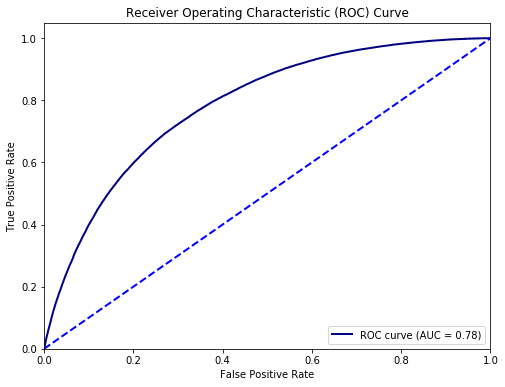

In [11]:
# Assuming X and y as features and target
X = X_train_res 
y = y_train_res  

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

f1_scores = []  # List to store F1 scores for each fold
roc_auc_scores = []  # List to store AUC scores for each fold
true_labels = []  # List to store true labels for ROC curve
pred_probs = []  # List to store predicted probabilities for ROC curve

# Loop through each fold
for train_idx, val_idx in skf.split(X, y):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32)
    
    # Initialize the model
    model = SimpleNN(input_size=X_train_fold.shape[1])
    
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    num_epochs = epochs # Number of epochs for training
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Zero out gradients from previous iteration

        # Forward pass
        outputs = model(X_train_tensor).squeeze(1)  # Get model predictions
        loss = criterion(outputs, y_train_tensor)  # Calculate the loss

        # Backward pass and optimization
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

    # Evaluate the model after training
    model.eval()
    with torch.no_grad():
        # Predict probabilities on the validation set
        outputs = model(X_val_tensor).squeeze(1)
        predicted = (outputs >= threshold).float()  # Convert probabilities to binary predictions

        # Calculate F1 Score
        f1 = f1_score(y_val_tensor.numpy(), predicted.numpy())
        f1_scores.append(f1)

        # Calculate ROC AUC Score
        auc_score = roc_auc_score(y_val_tensor.numpy(), outputs.numpy())
        roc_auc_scores.append(auc_score)

        # Store true labels and predicted probabilities for ROC curve
        true_labels.extend(y_val_tensor.numpy())
        pred_probs.extend(outputs.numpy())

# Calculate the average metrics over all folds
print(f'Mean F1 score: {np.mean(f1_scores):.4f}')
print(f'Standard Deviation of F1 score: {np.std(f1_scores):.4f}')
print(f'List of F1 Score from StratifiedKFold cross-validation: \n{f1_scores}')
print()
print(f"Average AUC Score: {np.mean(roc_auc_scores):.4f}")
print(f'Standard Deviation of AUC score: {np.std(roc_auc_scores):.4f}')
print(f'List of AUC Score from StratifiedKFold cross-validation: \n{roc_auc_scores}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
# Save the model
torch.save(model.state_dict(), 'trained_model.pth')
print("Model saved successfully.") # Confirmation message

Model saved successfully.


In [13]:
# Inference (for on the test data set)
# Load the test dataset
dftest = pd.read_csv("D:/processed_anomaly_testing_loan_data.csv", header=0)

X_new = dftest.drop(columns=['anomaly_score', 'anomaly', 'bad_flag'], errors='ignore')

# Apply the same scaling as during training
scaler = StandardScaler()  
X_new_scaled = scaler.fit_transform(X_new)  # Scale the test data set

# Convert the new data to a PyTorch tensor
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)

# Load the previously saved model for inference
model = SimpleNN(input_size=X_new_scaled.shape[1])  # Initialize model

try:
    model.load_state_dict(torch.load('trained_model.pth'))
    model.eval()  # Set model to evaluation mode
    print("Model loaded successfully")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}") # Handle file not found error

Model loaded successfully


In [20]:
threshold  = 0.85 # Set the threshold for binary classification

# Make predictions
with torch.no_grad():  # No gradient computation needed for inference
    outputs = model(X_new_tensor).squeeze(1)  # Get the model's output probabilities
    predictions = (outputs >= threshold).float()  # Convert output probabilities to binary predictions (0 or 1)

    # Convert the tensor to a list of predicted classes (0s and 1s)
    predictions_list = predictions.squeeze().tolist()  # Convert tensor to list
    
    # Convert the list values to integers for better readability
    predictions_int_list = [int(x) for x in predictions_list]
    # Display the first and last 100 predictions for inspection
    print(f'the fist 100 predected bad_flag:\n{predictions_int_list [:100]}')
    print(f'\nthe last 100 predected bad_flag:\n{predictions_int_list [-100:]}')

the fist 100 predected bad_flag:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

the last 100 predected bad_flag:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]


In [21]:
# check the ration of bad_flag 1:0 in the train and test df

# Count the number of predicted 1's (bad_flag = 1) in the predictions list
predtest = sum(1 for i in predictions_int_list if i == 1)
lentest = len(predictions_int_list)
print(f'the ratio of 1:0 in the predecited test df: {predtest / lentest}')

# Count the number of 1's (bad_flag = 1) in the original training dataset
predtrain = sum(1 for i in list(y_train) if i == 1)
lentrain = len(list(y_train))
print(f'\nthe ratio of 1:0 in the original train df: {predtrain / lentrain}')

the ratio of 1:0 in the predecited test df: 0.10299009804399785

the ratio of 1:0 in the original train df: 0.06938298183364563


In [22]:
dftest['bad_flag'] = predictions_int_list
dftest.head()

,id,member_id,loan_amnt,int_rate,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,tot_hi_cred_lim,tot_cur_bal,internal_score,anomaly_score,anomaly,bad_flag
0,20000001,22419852,10000,22.15,37000.0,80.0,83.0,28.51,1,3.0,73.1,16200,14877.170280,36809,131,0.115904,1,0
1,20000002,22349118,1400,18.24,41000.0,0.0,0.0,26.58,0,9.0,11.5,4000,4097.304770,19536,19,0.032762,1,0
2,20000003,22398818,7000,12.49,68900.0,60.0,75.9,6.60,0,11.0,48.1,11900,12688.495160,241465,92,0.124508,1,0
3,20000004,22419015,18000,16.29,41000.0,33.3,61.1,20.61,1,0.0,38.1,7600,7908.799817,179757,235,0.144529,1,0
4,20000005,22388614,12000,12.99,64000.0,75.0,67.0,24.61,0,6.0,57.9,21000,19378.561060,31953,157,0.161886,1,0
